In [1]:
import numpy as np

In [2]:
x = [[1, 2, 3, 4], [4, 5, 6, 2], [7, 8, 9, 1]]
x = np.array(x)
x

array([[1, 2, 3, 4],
       [4, 5, 6, 2],
       [7, 8, 9, 1]])

In [3]:
x.shape[0]

3

In [4]:
z = (x[0] - x[1])
(z**2).sum()

31

# Write the KNN Class

In [5]:
class KNNClassifier:
    def __init__(self, neighbors = 5) -> None:
        self.k = neighbors
        self.neighbors = []
        
        self.X = None
        self.y = None
        
        self.counts = dict()
        
    def train(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
        
        for i in y:
            if i not in self.counts.keys():
                self.counts[i] = 0
        
    def predict(self, X: np.ndarray):
        # number of examples to get neighbors from
        m = self.X.shape[0]
        
        # Number of features
        n = self.X.shape[1]
        
        # Answers for the array X given to classify
        answers = []
        
        # For each point we want to classify
        for x in X:
            
            # Get the distance from point to all saved examples from training
            for point in range(m):
                distance = np.sqrt(((x - self.X[point])**2).sum())
                self.neighbors.append((point, distance))
                
            # Once we got all examples and their distances from our point, sort them ascendingly based on distance
            self.neighbors.sort(key = lambda point_distance: point_distance[1])
            
            # Take the nearest k examples
            self.neighbors = self.neighbors[:self.k]
            
            # For each neighbor, make them vote for their class through the counts dictionary
            classes = self.counts.copy()
            for neighbor in self.neighbors:
                classes[self.y[neighbor[0]]] += 1
                
            # Get the class with majority of votes and put it into the answers
            winner_class = sorted(classes.items(), key = lambda class_votes: class_votes[1], reverse = True)[0][0]
            
            answers.append(winner_class)
            
            # Reset neighbors
            self.neighbors.clear()   
                
        return answers
                
                

# Lets test our class

In [6]:
import pandas as pd

*We will use MNSIT Dataset for testing*

In [7]:
mnsit = pd.read_csv('MNSIT.csv')

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
y = mnsit['label'][:5000]
X = mnsit[mnsit.columns[1:]][:5000]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 420, stratify = y)
knn = KNNClassifier(neighbors = 15)
knn.train(x_train.to_numpy(), y_train.to_numpy())

In [10]:
y_pred = knn.predict(x_test.to_numpy())

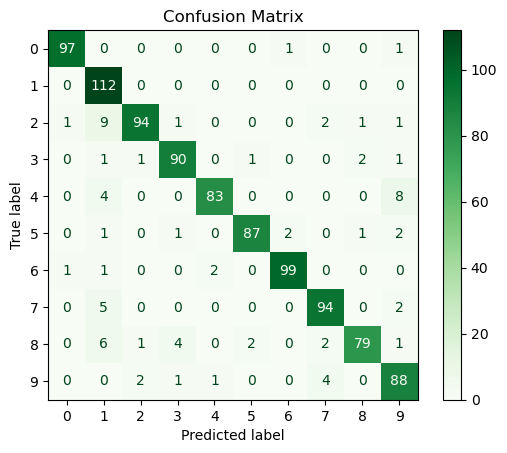

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

In [12]:
report = classification_report(y_test, y_pred, zero_division = 'warn')
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        99
           1       0.81      1.00      0.89       112
           2       0.96      0.86      0.91       109
           3       0.93      0.94      0.93        96
           4       0.97      0.87      0.92        95
           5       0.97      0.93      0.95        94
           6       0.97      0.96      0.97       103
           7       0.92      0.93      0.93       101
           8       0.95      0.83      0.89        95
           9       0.85      0.92      0.88        96

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000



In [13]:
acc = accuracy_score(y_test, y_pred)
acc

0.923